[오늘코드](https://www.inflearn.com/course/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%82%AC%EC%9D%B4%EC%96%B8%EC%8A%A4-kaggle#) 강의와 [EDA & Ensemble Model](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile/comments) 커널을 참고하여 캐글 입문 코드를 작성해봤습니다.

### 목차
1. Package & Data 패키지 및 데이터 준비
2. Feature Engineering
3. Modeling 모델링
4. Predict 예측
5. Conclusion 결언 및 요약
6. *windspeed*를 LGBM 모델로 보간한다면?

# 패키지 및 데이터 준비

In [2]:
### 패키지 및 설정 ###
import pandas as pd # DataFrame
import numpy as np # linear algebra
import seaborn as sns # visualization 
import matplotlib as mpl # visualization
import matplotlib.pyplot as plt #visualization
from scipy import stats # statistics
from datetime import datetime # datetime
import missingno as msno # missing values

# 그래프 설정
%matplotlib inline
plt.style.use('ggplot') #격자 그리기

# 폰트 설정
mpl.rcParams['axes.unicode_minus'] = False #마이너스 폰트 깨짐 문제
plt.rcParams['font.family'] = 'NanumSquareRound' #나눔스퀘어라운드 폰트 설정
plt.rcParams['font.size'] = 15 #폰트 크기 15
print('설정된 폰트 사이즈: ',plt.rcParams['font.size'])
print('설정된 폰트 글꼴: ',plt.rcParams['font.family'])

설정된 폰트 사이즈:  15.0
설정된 폰트 글꼴:  ['NanumSquareRound']


In [15]:
### 모델링 패키지 model ###
from sklearn.linear_model import LinearRegression, Ridge, Lasso #선형회귀, 릿지, 라쏘
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor #랜덤 포레스트, 그래디언트 부스트
from sklearn.ensemble import StackingRegressor,BaggingRegressor,AdaBoostRegressor
from lightgbm import LGBMRegressor # LightGBM


### 검증 패키지 evaluation ###
from sklearn.metrics import mean_squared_log_error,make_scorer # RMSLE
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict,GridSearchCV # validation

In [3]:
### 데이터 불러오기 ###
train = pd.read_csv('train.csv',parse_dates = ['datetime'])
test = pd.read_csv('test.csv',parse_dates = ['datetime'])
submission = pd.read_csv('sampleSubmission.csv',parse_dates = ['datetime'])

# Feature Engineering

### 이상치 처리

In [5]:
### IQR 범위 설정 ###
IQR=train['count'].quantile(q=0.75)-train['count'].quantile(q=0.25)
IQR_l=train['count'].quantile(q=0.25)-1.5*IQR
IQR_u=train['count'].quantile(q=0.75)+1.5*IQR

### remove outliers 이상치 제거 ###
train_Outliers = train[train['count']>=IQR_l]
train_Outliers = train_Outliers[train_Outliers['count']<=IQR_u]
print(f'train:{train.shape},train without Outliers:{train_Outliers.shape}')
print(f'remove:{train.shape[0]-train_Outliers.shape[0]}')

train:(10886, 12),train without Outliers:(10586, 12)
remove:300


### 날짜 세분화

In [6]:
# datetime 형식이라 가능한 연산
train_Outliers['year'] = train_Outliers['datetime'].dt.year #연도
train_Outliers['month'] = train_Outliers['datetime'].dt.month #월
train_Outliers['day'] = train_Outliers['datetime'].dt.day #일
train_Outliers['hour'] = train_Outliers['datetime'].dt.hour #시간
train_Outliers['minute'] = train_Outliers['datetime'].dt.minute #분
train_Outliers['second'] = train_Outliers['datetime'].dt.second #초
train_Outliers['dayofweek'] = train_Outliers['datetime'].dt.dayofweek #요일

In [7]:
# test 데이터 변환
test['year'] = test['datetime'].dt.year #연도
test['month'] = test['datetime'].dt.month #월
test['day'] = test['datetime'].dt.day #일
test['hour'] = test['datetime'].dt.hour #시간
test['minute'] = test['datetime'].dt.minute #분
test['second'] = test['datetime'].dt.second #초
test['dayofweek'] = test['datetime'].dt.dayofweek #요일

### 풍속(windspeed)의 0을 RandomForest로 보간

In [8]:
train_Outliers.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

In [9]:
# windspeed =0인 데이터와 !=0인 데이터로 나누기
trainWind0 = train_Outliers[train_Outliers['windspeed']==0]
trainWindNot0 = train_Outliers[train_Outliers['windspeed']!=0]

#windspeed 예측 모델
rf_wind = RandomForestRegressor()

#모델 피처
windCols = ['season','weather','temp','atemp','humidity','year','month','day','hour']

#학습
rf_wind.fit(trainWindNot0[windCols],trainWindNot0['windspeed'])

#예측
trainWind0['windspeed'] = rf_wind.predict(trainWind0[windCols])

## 다시 학습데이터로 합치기
train_wind = trainWindNot0.append(trainWind0)
train_wind.reset_index(inplace = True)
train_wind.drop('index',inplace=True,axis=1)
train_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10586 entries, 0 to 10585
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10586 non-null  datetime64[ns]
 1   season      10586 non-null  int64         
 2   holiday     10586 non-null  int64         
 3   workingday  10586 non-null  int64         
 4   weather     10586 non-null  int64         
 5   temp        10586 non-null  float64       
 6   atemp       10586 non-null  float64       
 7   humidity    10586 non-null  int64         
 8   windspeed   10586 non-null  float64       
 9   casual      10586 non-null  int64         
 10  registered  10586 non-null  int64         
 11  count       10586 non-null  int64         
 12  year        10586 non-null  int64         
 13  month       10586 non-null  int64         
 14  day         10586 non-null  int64         
 15  hour        10586 non-null  int64         
 16  minute      10586 non-

C:\Users\genie\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


# Modeling & Evaluation
1. Linear regression 선형 회귀 모델
2. Regularization 정규화 Ridge
3. Regularization 정규화 Lasso
4. Ensemble Random Forest 랜덤 포레스트
5. Ensemble GradientBoost 그래디언트 부스트
6. Ensemble AdaBoost 아다 부스트
7. Ensemble Bagging 배깅
8. LGBM
9. Ensemble Stacking 스태킹
    1. (LGBM+RandomForest+Bagging+GBM)->LGBM
    2. (LGBM+RandomForest+Bagging+GBM)->RandomForest
    3. (LGBM+RandomForest+Bagging+GBM)->Bagging
    4. (LGBM+RandomForest+Bagging+GBM)->GBM

### Splitting Data set - Train/Test

In [10]:
train_wind.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

In [11]:
# 피처 분류하기
categoricalFeatureNames = ['season','holiday','workingday','weather','month','year','hour','dayofweek']
numericFeatureNames = ['temp','humidity','windspeed','atemp']
dropFeatureNames = ['casual','registered','minute','second','count']

# Categorical 피처 타입 변환 - 라벨인코딩은 할 필요 없다
for var in categoricalFeatureNames:
    train_wind[var] = train_wind[var].astype('category')
    test[var] = test[var].astype('category')

In [12]:
### Train / Test Split ###
X_train = train_wind[categoricalFeatureNames+numericFeatureNames]
X_test = test[categoricalFeatureNames+numericFeatureNames]

y_train = np.log(train_wind['count'])

### Evaluation 평가지표 RMSLE

In [13]:
### 그리드서치를 위한 RMSLE 함수 ###
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

rmsle_scorer = make_scorer(rmsle,greater_is_better=False) #rmsle는 작을수록 좋다

### Linear regression 선형회귀

In [31]:
### 모델 생성 ###
reg = LinearRegression()

### 모델 학습 ###
reg.fit(X=X_train,y=y_train)

### 평가 ###
k_fold = KFold(n_splits=10, shuffle=True, random_state=22)
pred_reg = cross_val_predict(reg, X_train, y_train, cv=k_fold)
reg_score = mean_squared_log_error(y_train, pred_reg)
print(f'10-fold RMSLE score:{reg_score}')

10-fold RMSLE score:0.07462256861519097


### Regularization Ridge [참고](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- 기본 모델: `Ridge`에 cross-validation을 더한 모델
    - RMSLE: 1.0224845936149742

In [16]:
### 모델 생성 ###
ridge = Ridge()

### 모델 학습 ###
ridge.fit(X=X_train,y=y_train)

### 평가 ###
k_fold = KFold(n_splits=10, shuffle=True, random_state=22)
pred_ridge = cross_val_predict(ridge, X_train, y_train, cv=k_fold)
ridge_score = mean_squared_log_error(np.exp(y_train), np.exp(pred_ridge))
print(f'10-fold RMSLE score:{ridge_score}')

10-fold RMSLE score:1.0225855296688027


- GridSeachCV Hyperparameter Tuning: 1.0195900708376755
    - `max_iter`: 50,100,200,500,1000,2000,**3000**
    - `alpha`: .1,.5,1,2,5,10,50,75,**100**,300,500,1000

In [19]:
### 모델 생성 - 그리드서치 ###
ridge = Ridge()
ridge_params = {'max_iter':[3000],'alpha':[.01,.05,.1,.5,1,5,10,20,50,80,100,200,500,800,1000]}
grid_ridge = GridSearchCV(ridge,ridge_params,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_ridge.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GRidge = grid_ridge.predict(X=X_train)
GRidge_score = mean_squared_log_error(np.exp(y_train),np.exp(pred_GRidge))
print('Best params of Ridge: ',grid_ridge.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GRidge_score}')

Best params of Ridge:  <bound method BaseEstimator.get_params of Ridge(alpha=100, max_iter=3000)>
10-fold GridSearchCV RMSLE score:1.0196915524419168


### Regularization Lasso

In [58]:
### 모델 생성 ###
lasso = Lasso()

### 모델 학습 ###
lasso.fit(X=X_train,y=y_train)

### 평가 ###
k_fold = KFold(n_splits=10, shuffle=True, random_state=22)
pred_lasso = cross_val_predict(lasso, X_train, y_train, cv=k_fold)
lasso_score = mean_squared_log_error(np.exp(y_train), np.exp(pred_lasso))
print(f'10-fold RMSLE score:{lasso_score}')

10-fold RMSLE score:1.1124566661835453


- GridSeachCV Hyperparameter Tuning
    - `max_iter`:100,**300**,500,600,1000,2000
    - `alpha`:**.01**,.05,.1,.5,1,2,5,10,50,100,500,1000

In [76]:
### 모델 생성 - 그리드서치 ###
lasso = Lasso()
lasso_params = {'max_iter':[3000],'alpha':[.005,.01,.05,.1,.5,1,2,5,10,50,100]}
grid_lasso = GridSearchCV(lasso,lasso_params,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_lasso.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GLasso = grid_lasso.predict(X=X_train)
GLasso_score = mean_squared_log_error(np.exp(y_train),np.exp(pred_GLasso))
print('Best params of Ridge: ',grid_lasso.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GLasso_score}')

Best params of Ridge:  {'alpha': 0.01, 'max_iter': 3000}
10-fold GridSearchCV RMSLE score:1.0200481779275337


### Ensemble Random Forest
- 기본 모델

In [64]:
### 모델 생성 ###
rf = RandomForestRegressor()

### 모델 학습 ###
rf.fit(X=X_train,y=y_train)

### 평가 ###
k_fold = KFold(n_splits=10, shuffle=True, random_state=22)
pred_rf = cross_val_predict(rf, X_train, y_train, cv=k_fold)
rf_score = mean_squared_log_error(np.exp(y_train), np.exp(pred_rf))
print(f'10-fold RMSLE score:{rf_score}')

10-fold RMSLE score:0.09011174579152982


- GridSeachCV Hyperparameter Tuning
    - `max_depth`: 10, 50, 100, **None**
    - `n_estimators`: 50, 100, 200, 300, **500**, 1000

In [143]:
### 모델 생성 - 그리드서치 ###
rf = RandomForestRegressor()
rf_params2 = {'max_depth': [100],
             'n_estimators': [100, 300, 500, 1000]}
grid_rf2 = GridSearchCV(rf,rf_params2,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_rf2.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GRF2 = grid_rf2.predict(X=X_train)
GRF_score2 = mean_squared_log_error(np.exp(y_train),np.exp(pred_GRF2))
print('Best params of RandomForest: ',grid_rf2.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GRF_score2}')

Best params of RandomForest:  {'max_depth': 100, 'n_estimators': 1000}
10-fold GridSearchCV RMSLE score:0.011789943431748478


1. `max_depth`=None / `n_estimators`=500  <u>0.011912291790904564</u>
2. `max_depth`=100 / `n_estimators`=1000  <u>0.011789943431748478</u>

### Ensemble Gradient Boosting
- 기본 모델

In [77]:
### 모델 생성 ###
gbm = GradientBoostingRegressor()

### 모델 학습 ###
gbm.fit(X=X_train,y=y_train)

### 평가 ###
k_fold = KFold(n_splits=10, shuffle=True, random_state=22)
pred_gbm = cross_val_predict(gbm, X_train, y_train, cv=k_fold)
gbm_score = mean_squared_log_error(np.exp(y_train), np.exp(pred_gbm))
print(f'10-fold RMSLE score:{gbm_score}')

10-fold RMSLE score:0.15228860047945575


- GridSeachCV Hyperparameter Tuning
    - `max_depth`: 3,4,**5**,6
    - `learning_rate`: .001, .005, .01, .025, **.05**, .075, .1
    - `n_estimators`: 50, 100, 250, **500**, 750, 1000, 1500

In [145]:
### 모델 생성 - 그리드서치 ###
gbm = GradientBoostingRegressor()
gbm_params2 = {'max_depth':[4,5,6],'learning_rate':[0.025,.05,0.075], 'n_estimators':[250,500,750]}
grid_gbm2 = GridSearchCV(gbm,gbm_params2,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_gbm2.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GGbm2 = grid_gbm2.predict(X=X_train)
GGbm_score2 = mean_squared_log_error(np.exp(y_train),np.exp(pred_GGbm2))
print('Best params of GradientBoost: ',grid_gbm2.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GGbm_score2}')

Best params of GradientBoost:  {'learning_rate': 0.075, 'max_depth': 5, 'n_estimators': 250}
10-fold GridSearchCV RMSLE score:0.054443527910711935


1. `learning_rate`=0.05 / `max_depth`=5 / `n_estimators`=500   <u>0.04950393455023469</u>
2. `learning_rate`=0.075 / `max_depth`=5 / `n_estimators`=250   <u>0.054443527910711935</u>

### Ensemble AdaBoostRegressor [참고](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)
- 기본 모델: 0.453708645072753

In [126]:
### 모델 생성 ###
ada = AdaBoostRegressor()

### 모델 학습 ###
ada.fit(X=X_train,y=y_train)

### 평가 ###
k_fold = KFold(n_splits=10, shuffle=True, random_state=22)
pred_ada = cross_val_predict(ada, X_train, y_train, cv=k_fold)
ada_score = mean_squared_log_error(np.exp(y_train), np.exp(pred_ada))
print(f'10-fold RMSLE score:{ada_score}')

10-fold RMSLE score:0.453708645072753


- GridSearchCV Hyperparameter Tuning

In [129]:
### 모델 생성 - 그리드서치 ###
ada = AdaBoostRegressor()
ada_params = {'loss':['linear','exponential'],'learning_rate':[.005,.01,.05,.1], 'n_estimators':[30,50,100,200,500,1000]}
grid_ada = GridSearchCV(ada,ada_params,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_ada.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GAda = grid_ada.predict(X=X_train)
GAda_score = mean_squared_log_error(np.exp(y_train),np.exp(pred_GAda))
print('Best params of AdaBoostRegressor: ',grid_ada.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GAda_score}')

Best params of AdaBoostRegressor:  {'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 500}
10-fold GridSearchCV RMSLE score:0.40669772983181673


### Ensemble BaggingRegressor [참고](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html?highlight=baggingregressor)
- 기본 모델: 0.10087627581459563

In [127]:
### 모델 생성 ###
bag = BaggingRegressor()

### 모델 학습 ###
bag.fit(X=X_train,y=y_train)

### 평가 ###
k_fold = KFold(n_splits=10, shuffle=True, random_state=22)
pred_bag = cross_val_predict(bag, X_train, y_train, cv=k_fold)
bag_score = mean_squared_log_error(np.exp(y_train), np.exp(pred_bag))
print(f'10-fold RMSLE score:{bag_score}')

10-fold RMSLE score:0.10087627581459563


- GridSearchCV Hyperparameter Tuning

In [133]:
bag.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [134]:
### 모델 생성 - 그리드서치 ###
bag = BaggingRegressor()
bag_params2 = {'n_estimators':[500,600,700,800,900,1000]}
grid_bag2 = GridSearchCV(bag,bag_params2,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_bag2.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GBag2 = grid_bag2.predict(X=X_train)
GBag_score2 = mean_squared_log_error(np.exp(y_train),np.exp(pred_GBag2))
print('Best params of BaggingRegressor: ',grid_bag2.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GBag_score2}')

Best params of BaggingRegressor:  {'n_estimators': 1000}
10-fold GridSearchCV RMSLE score:0.01171767447097983


1. `n_estimators`=1000   <u>0.01171767447097983</u>

### LGBM lightgbm [참고](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)
- 기본 모델

In [79]:
### 모델 생성 ###
lgbm = LGBMRegressor()

### 모델 학습 ###
lgbm.fit(X=X_train,y=y_train)

### 평가 ###
k_fold = KFold(n_splits=10, shuffle=True, random_state=22)
pred_lgbm = cross_val_predict(lgbm, X_train, y_train, cv=k_fold)
lgbm_score = mean_squared_log_error(np.exp(y_train), np.exp(pred_lgbm))
print(f'10-fold RMSLE score:{lgbm_score}')

10-fold RMSLE score:0.08430989074757703


- GridSeachCV Hyperparameter Tuning
    - [LGBM Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
    
#### LGBM parameter tuning 방법
- 빠른 분석을 위한 parameter tuning
    1. `bagging_fraction`과 `bagging_freq` 설정
    2. `feature_fraction`으로 feature sub-sampling
    3. `max_bin`를 더 **작게** 설정
    4. `save_binary` 설정
- 정확도를 높이기 위한 parameter tuning
    1. `max_bin`을 더 **크게** 설정(단, 속도가 느려진다)
    2. `learning_rate`를 **작게**, `num_iterations`를 **크게** 설정
    3. `num_leaves`를 더 **크게** (단, overfitting 주의)
    4. `dart` 사용
- over-fitting에 대응하기 위한 parameter tuning
    1. `max_bin`을 더 **작게**
    2. `num_leaves`를 더 **작게**
    3. `min_data_in_leaf`와 `min_sum_hessian_in_leaf` 설정
    4. `bagging_fraction`과 `bagging_freq`을 설정
    5. `feature_fraction`으로 feature을 sub-sampling
    6. `lambda_l1`,`lambda_l2`,`min_gain_to_split`같은 규제 걸기
    7. `max_depth`를 설정해서 과적합 방지
    8. `extra_trees`를 설정하거나 `path_smooth` 높이기

In [148]:
### 모델 생성 - 그리드서치 ###
lgbm = LGBMRegressor()
lgbm_params2 = {'boosting_type':['gbdt','dart'],'max_depth':[8],'learning_rate':[.05,.1,.2], 'num_leaves':[10,20,50,75,100]}
grid_lgbm2 = GridSearchCV(lgbm,lgbm_params2,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_lgbm2.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GLgbm2 = grid_lgbm2.predict(X=X_train)
GLgbm_score2 = mean_squared_log_error(np.exp(y_train),np.exp(pred_GLgbm2))
print('Best params of GradientBoost: ',grid_lgbm2.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GLgbm_score2}')

Best params of GradientBoost:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 50}
10-fold GridSearchCV RMSLE score:0.049860846702498296


1. `boosting_type`=gbdt / `learning_rate`=0.1 / `max_depth`=8 / `num_leaves`=50   <u>0.049860846702498296</u>

In [52]:
### 모델 생성 - 그리드서치 ###
lgbm = LGBMRegressor()
lgbm_params3 = {'boosting_type':['dart','gbdt','rf','goss'],'max_depth':[7],'learning_rate':[.1], 'num_leaves':[50,60,75,80,90]}
grid_lgbm3 = GridSearchCV(lgbm,lgbm_params3,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_lgbm3.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GLgbm3 = grid_lgbm3.predict(X=X_train)
GLgbm_score3 = mean_squared_log_error(np.exp(y_train),np.exp(pred_GLgbm3))
print('Best params of GradientBoost: ',grid_lgbm3.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GLgbm_score3}')

C:\Users\genie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\genie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 743, in fit
    callbacks=callbacks)
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\basic.py", li

Best params of GradientBoost:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 75}
10-fold GridSearchCV RMSLE score:0.045410898920859755


In [54]:
### 모델 생성 - 그리드서치 ###
lgbm = LGBMRegressor()
lgbm_params4 = {'boosting_type':['dart','gbdt'],'max_depth':[8],'learning_rate':[.1], 'num_leaves':[90,100,120,130,150]}
grid_lgbm4 = GridSearchCV(lgbm,lgbm_params4,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_lgbm4.fit(X=X_train,y=y_train)

### 예측 및 성능 평가 ###
pred_GLgbm4 = grid_lgbm4.predict(X=X_train)
GLgbm_score4 = mean_squared_log_error(np.exp(y_train),np.exp(pred_GLgbm4))
print('Best params of GradientBoost: ',grid_lgbm4.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GLgbm_score4}')

Best params of GradientBoost:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 100}
10-fold GridSearchCV RMSLE score:0.037684855853047976


### Ensemble Stacking
- (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`LGBM`
    - 0.05188634666056914

In [175]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
             ('gbm',GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)),
             ('bag',BaggingRegressor(n_estimators=1000)),
             ('lgbm',LGBMRegressor(max_depth=8, num_leaves=50))]
# 최종 모델
stack_lgbm = StackingRegressor(estimators=estimators,final_estimator=lgbm)

#학습
stack_lgbm.fit(X=X_train,y=y_train)

# 성능평가
pred_stack1 = stack_lgbm.predict(X=X_train)
stack_score1 = mean_squared_log_error(np.exp(y_train),np.exp(pred_stack1))
print(f'Stacking RMSLE score:{stack_score1}')

Stacking RMSLE score:0.05188634666056914


- (`GBM1`+`RandomForest2`+`Bagging`)->`LGBM`
    - 0.04926024253144575

In [30]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
             ('gbm',GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)),
             ('bag',BaggingRegressor(n_estimators=1000))]
# 최종 모델
stack_lgbm2 = StackingRegressor(estimators=estimators,final_estimator=LGBMRegressor(max_depth=8, num_leaves=50))

#학습
stack_lgbm2.fit(X=X_train,y=y_train)

# 성능평가
pred_stack1_2 = stack_lgbm2.predict(X=X_train)
stack_score1_2 = mean_squared_log_error(np.exp(y_train),np.exp(pred_stack1_2))
print(f'Stacking RMSLE score:{stack_score1_2}')

Stacking RMSLE score:0.04926024253144575


- (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`LGBM`
    - 0.05000356808343325

In [32]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
             ('gbm',GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)),
             ('bag',BaggingRegressor(n_estimators=1000))]
# 최종 모델
stack_lgbm3 = StackingRegressor(estimators=estimators,final_estimator=LGBMRegressor(max_depth=8, num_leaves=50))

#학습
stack_lgbm3.fit(X=X_train,y=y_train)

# 성능평가
pred_stack1_3 = stack_lgbm3.predict(X=X_train)
stack_score1_3 = mean_squared_log_error(np.exp(y_train),np.exp(pred_stack1_3))
print(f'Stacking RMSLE score:{stack_score1_3}')

Stacking RMSLE score:0.05000356808343325


- (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`RandomForest`
    - 0.05868519594395292

In [180]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
             ('gbm',GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)),
             ('bag',BaggingRegressor(n_estimators=1000)),
             ('lgbm',LGBMRegressor(max_depth=8, num_leaves=50))]
# 최종 모델
stack_rf = StackingRegressor(estimators=estimators,final_estimator=rf)

#학습
stack_rf.fit(X=X_train,y=y_train)

# 성능평가
pred_stack2 = stack_rf.predict(X=X_train)
stack_score2 = mean_squared_log_error(np.exp(y_train),np.exp(pred_stack2))
print(f'Stacking RMSLE score:{stack_score2}')

Stacking RMSLE score:0.05868519594395292


- (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`Bagging`

In [182]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
             ('gbm',GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)),
             ('bag',BaggingRegressor(n_estimators=1000)),
             ('lgbm',LGBMRegressor(max_depth=8, num_leaves=50))]
# 최종 모델
stack_bag = StackingRegressor(estimators=estimators,final_estimator=bag)

#학습
stack_bag.fit(X=X_train,y=y_train)

# 성능평가
pred_stack3 = stack_bag.predict(X=X_train)
stack_score3 = mean_squared_log_error(np.exp(y_train),np.exp(pred_stack3))
print(f'Stacking RMSLE score:{stack_score3}')

Stacking RMSLE score:0.06730925587707606


- (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`GBM`

In [184]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
             ('gbm',GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)),
             ('bag',BaggingRegressor(n_estimators=1000)),
             ('lgbm',LGBMRegressor(max_depth=8, num_leaves=50))]
# 최종 모델
stack_gbm = StackingRegressor(estimators=estimators,final_estimator=gbm)

#학습
stack_gbm.fit(X=X_train,y=y_train)

# 성능평가
pred_stack4 = stack_gbm.predict(X=X_train)
stack_score4 = mean_squared_log_error(np.exp(y_train),np.exp(pred_stack4))
print(f'Stacking RMSLE score:{stack_score4}')

Stacking RMSLE score:0.04824021619497363


- (`RandomForest2`+`Bagging`+`LGBM`)->`GBM1`
    - 0.04874068995736984

In [34]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
              ('bag',BaggingRegressor(n_estimators=1000)),
              ('lgbm',LGBMRegressor(max_depth=8, num_leaves=50))]
# 최종 모델
stack_gbm2 = StackingRegressor(estimators=estimators,final_estimator=GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500))

#학습
stack_gbm2.fit(X=X_train,y=y_train)

# 성능평가
pred_stack4_2 = stack_gbm2.predict(X=X_train)
stack_score4_2 = mean_squared_log_error(np.exp(y_train),np.exp(pred_stack4_2))
print(f'Stacking RMSLE score:{stack_score4_2}')

Stacking RMSLE score:0.04874068995736984


- (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`GBM1`
    - 0.05339013878676392

In [36]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
             ('gbm',GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)),
             ('bag',BaggingRegressor(n_estimators=1000)),
             ('lgbm',LGBMRegressor(max_depth=8, num_leaves=50))]
# 최종 모델
stack_gbm3 = StackingRegressor(estimators=estimators,final_estimator=GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500))

#학습
stack_gbm3.fit(X=X_train,y=y_train)

# 성능평가
pred_stack4_3 = stack_gbm3.predict(X=X_train)
stack_score4_3 = mean_squared_log_error(np.exp(y_train),np.exp(pred_stack4_3))
print(f'Stacking RMSLE score:{stack_score4_3}')

Stacking RMSLE score:0.05339013878676392


# Predict

In [171]:
scores = {grid_ridge.best_estimator_:GRidge_score,grid_lasso.best_estimator_:GLasso_score,
          grid_rf2.best_estimator_:GRF_score2,grid_gbm.best_estimator_:GGbm_score,
          grid_lgbm.best_estimator_:GLgbm_score,grid_ada.best_estimator_:GAda_score,
          grid_bag.best_estimator_:GBag_score,reg:reg_score
         }
print('scores: ',sorted(scores, key=lambda x : scores[x], reverse=False))

scores:  [BaggingRegressor(n_estimators=1000), RandomForestRegressor(max_depth=100, n_estimators=1000), GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500), LGBMRegressor(max_depth=8, num_leaves=50), LinearRegression(), AdaBoostRegressor(learning_rate=0.05, loss='exponential', n_estimators=500), Ridge(alpha=100, max_iter=3000), Lasso(alpha=0.01, max_iter=3000)]


In [56]:
#best_model = sorted(scores, key=lambda x : scores[x], reverse=False)[5]
#pred = best_model.predict(X_test)
pred = grid_lgbm4.predict(X_test)
sub = pd.DataFrame({'datetime':submission['datetime'],'count':[max(0,x) for x in np.exp(pred)]})
sub.to_csv('bike_lgbm4.csv',index=False)

# Conclusion

### 단일모델 성능 비교(그리드서치 후)
1. RMSLE 자체 성능 비교
    1. **배깅**: **0.01171767447097983**
    2. 랜덤포레스트: 0.011912291790904564
    3. 그래디언트 부스트: 0.04950393455023469
    4. LGBM: 0.049860846702498296
        1. {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 75}: 0.045410898920859755
        2. {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 100}: 0.037684855853047976
    5. 선형회귀: 0.07462256861519097
    6. 아다 부스트: 0.40669772983181673
    7. Ridge: 1.0195900708376755
    8. Lasso: 1.0200481779275337

2. submission 제출 결과
    1. **LGBM**: 0.40698
        1. {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 75}: 0.40675
        2. {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 100}: **0.40481**
    2. 그래디언트 부스트: 0.42129(ver2. 0.42631)
    3. 배깅: 0.43001
    4. 랜덤포레스트: 0.42909(ver1. 0.43014)
    5. 아다 부스트: 0.69576
    6. Lasso: 1.04061
    7. Ridge: 1.04955
    8. 선형회귀: 1.05203
    

- 앙상블 모델의 성능이 전반적으로 더 우수하게 나타난다
- RMSLE 자체 성능 비교와 submission결과의 차이가 있다. 즉, 과대추정으로 인한 오류가 발생했을 수도 있다
    - 상위 4개 모델을 사용하여 3개 모델을 쌓고 가장 성능이 좋은 모델로 stacking해보자
    
### 다중모델 Stacking 성능 비교
1. RMSLE 자체 성능 비교
    1. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`LGBM`: 0.05188634666056914
        2. (`GBM1`+`RandomForest2`+`Bagging`)->`LGBM`: 0.04926024253144575
        3. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`LGBM`: 0.05000356808343325
    2. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`RF`: 0.05868519594395292
    3. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`Bagging`: 0.06730925587707606
    4. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`GBM`: 0.04824021619497363
        2. (`RandomForest2`+`Bagging`+`LGBM`)->`GBM1`: 0.04874068995736984
        3. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`GBM1`: 0.05339013878676392

2. submission 제출 결과
    1. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`LGBM`: 0.41933
        2. (`GBM1`+`RandomForest2`+`Bagging`)->`LGBM`: 0.42888
        3. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`LGBM`: 0.42211
    2. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`RF`: 0.42357
    3. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`Bagging`:0.43150
    4. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`GBM`:0.41299
        2. (`RandomForest2`+`Bagging`+`LGBM`)->`GBM1`: 0.41298
        3. (`GBM1`+`RandomForest2`+`Bagging`+`LGBM`)->`GBM1`:0.41689

In [94]:
### 모델별 파라미터와 RMSLE, submission 스코어 ###

result = pd.DataFrame({'model':[],'params':[],'RMSLE':[],'submission':[]})

result.loc[0] = ['Regression','',reg_score,1.05203]
result.loc[1] = ['Ridge',grid_ridge.best_estimator_,GRidge_score,1.04955]
result.loc[2] = ['Lasso',grid_lasso.best_estimator_,GLasso_score,1.04061]
result.loc[3] = ['RandomForest1',grid_rf.best_estimator_,GRF_score,0.43014]
result.loc[4] = ['RandomForest2',grid_rf2.best_estimator_,GRF_score2,0.42909]
result.loc[5] = ['GradientBoost1',grid_gbm.best_estimator_,GGbm_score,0.42129]
result.loc[6] = ['GradientBoost2',grid_gbm2.best_estimator_,GGbm_score2,0.42631]
result.loc[7] = ['LGBM2',grid_lgbm2.best_estimator_,GLgbm_score2,0.40698]
result.loc[8] = ['AdaBoost',grid_ada.best_estimator_,GAda_score,0.69576]
result.loc[9] = ['Bagging',grid_bag.best_estimator_,GBag_score,0.43001]
result.loc[10] = ['Stacking1','GBM1+RandomForest2+Bagging+LGBM)->LGBM',stack_score1,0.41933]
result.loc[11] = ['Stacking2','GBM1+RandomForest2+Bagging+LGBM)->RF',stack_score2,0.42357]
result.loc[12] = ['Stacking3','GBM1+RandomForest2+Bagging+LGBM)->Bag',stack_score3,0.43150]
result.loc[13] = ['Stacking4','GBM1+RandomForest2+Bagging+LGBM)->GBM',stack_score4,0.41299]
result.loc[14] = ['Stacking1_2','GBM1+RandomForest2+Bagging->LGBM',stack_score1_2,0.42888]
result.loc[15] = ['Stacking1_3','GBM1+RandomForest2+Bagging+LGBM->LGBM',stack_score1_3,0.42211]
result.loc[16] = ['Stacking4_2','LGBM+RandomForest2+Bagging->GBM1',stack_score4_2,0.41298]
result.loc[17] = ['Stacking4_3','GBM1+RandomForest2+Bagging+LGBM->GBM1',stack_score4_3,0.41689]
result.loc[18] = ['LGBM3',grid_lgbm3.best_estimator_,GLgbm_score3,0.40675]
result.loc[19] = ['LGBM4',grid_lgbm4.best_estimator_,GLgbm_score4,0.40481]

result.sort_values(by=['submission'])

,model,params,RMSLE,submission
19,LGBM4,"LGBMRegressor(max_depth=8, num_leaves=100)",0.037685,0.40481
18,LGBM3,"LGBMRegressor(max_depth=7, num_leaves=75)",0.045411,0.40675
7,LGBM2,"LGBMRegressor(max_depth=8, num_leaves=50)",0.049861,0.40698
16,Stacking4_2,LGBM+RandomForest2+Bagging->GBM1,0.048741,0.41298
13,Stacking4,GBM1+RandomForest2+Bagging+LGBM)->GBM,0.048240,0.41299
17,Stacking4_3,GBM1+RandomForest2+Bagging+LGBM->GBM1,0.053390,0.41689
10,Stacking1,GBM1+RandomForest2+Bagging+LGBM)->LGBM,0.051886,0.41933
5,GradientBoost1,"GradientBoostingRegressor(learning_rate=0.05,m...",0.049504,0.42129
15,Stacking1_3,GBM1+RandomForest2+Bagging+LGBM->LGBM,0.050004,0.42211
11,Stacking2,GBM1+RandomForest2+Bagging+LGBM)->RF,0.058685,0.42357


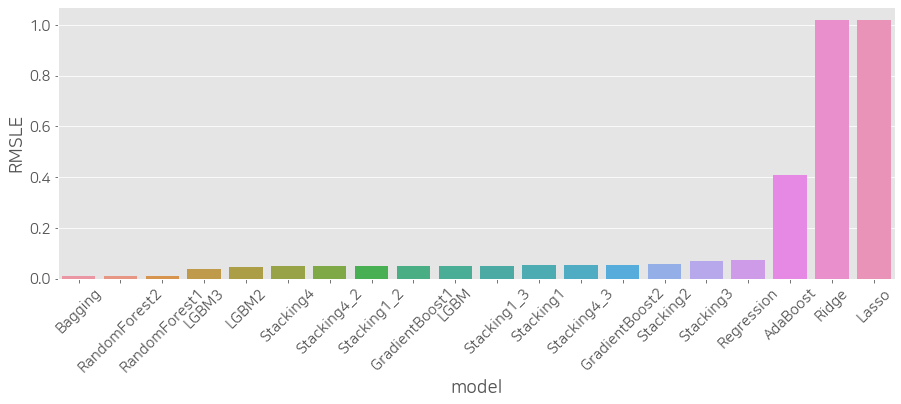

In [58]:
### RMSLE 스코어 순위 시각화 ###
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

plt.xticks(rotation=45)
sns.barplot(data=result.sort_values(['RMSLE']),x='model',y='RMSLE',ax=ax)

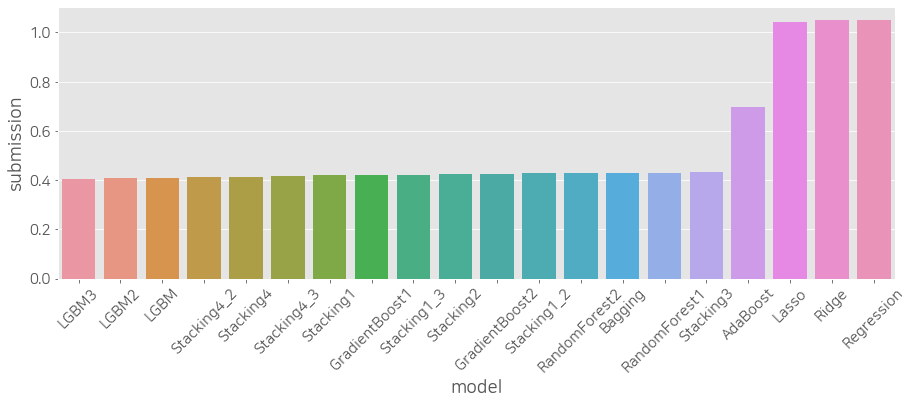

In [59]:
### submission 스코어 순위 시각화 ###
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

plt.xticks(rotation=45)
sns.barplot(data=result.sort_values(['submission']),x='model',y='submission',ax=ax)

### 결론
- RMSLE 함수로 자체 스코어를 계산한 결과와 실제 submission 제출 결과에 차이가 있다. RMSLE 스코어는 낮지만 submission 스코어가 큰 모델은 over-fitting을 의심할 수 있다.
    - over-fitting 의심: bagging, regression, randomforest1, randomforest2

- 반면 RMSLE 스코어로 순위를 매겼을 때 상위 모델은 아니지만, 실제 submission 제출 결과 순위가 상승한 모델이 여러개 있다.
    - LGBM, stacking1, stacking4 등
    - 전반적으로 LGBM,GBM이 over-fitting 위험이 낮으며 실제 submission 제출 결과, 스코어가 향상되는 경향이 보인다
    
- 가장 성능이 좋은 모델은 **LGBM 단일 모델**이다.(submission 스코어 0.40481(상위 약 8%))
> 3242팀 중 262위인데, 종료된 대회이므로 순위는 정확한 수치가 아니다
    
    - 전반적으로 LGBM의 submission 스코어가 높은 편이며, LGBM 단일모델 간의 비교를 해보면 RMSLE 자체 평가와 submission 스코어 순위 차이가 없는 것을 알 수 있다.

### 알 수 있는 점
- RMSLE 같은 평가지표로 자체 순위를 매긴 것과 실제 submission 제출 결과는 다를 수 있다. 제작한 모델 모두 submission 파일을 제작해서 직접 스코어를 평가할 필요가 있다. 앞으로 대회 출전 시, 1일 제출량에 따라 최대한 빨리 모델을 구축해서 여러번 검증해보는 것이 좋다.
- 오버피팅의 문제는 상당히 성능에 많은 영향을 미친다. 오버피팅을 줄이기 위한 모델 구축이 가장 중요하다.
- Stacking 모델이 꼭 가장 좋은 성능을 보이는 것은 아니다.

## windspeed을 LGBM 모델로 보간 한다면?

In [61]:
# windspeed =0인 데이터와 !=0인 데이터로 나누기
trainWind02 = train_Outliers[train_Outliers['windspeed']==0]
trainWindNot02 = train_Outliers[train_Outliers['windspeed']!=0]

#windspeed 예측 모델
lgbm_wind = LGBMRegressor()

#모델 피처
#windCols = ['season','weather','temp','atemp','humidity','year','month','day','hour']

#학습
lgbm_wind.fit(trainWindNot02[windCols],trainWindNot02['windspeed'])

#예측
trainWind02['windspeed'] = lgbm_wind.predict(trainWind02[windCols])

## 다시 학습데이터로 합치기
train_wind2 = trainWindNot02.append(trainWind02)
train_wind2.reset_index(inplace = True)
train_wind2.drop('index',inplace=True,axis=1)
train_wind2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10586 entries, 0 to 10585
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10586 non-null  datetime64[ns]
 1   season      10586 non-null  int64         
 2   holiday     10586 non-null  int64         
 3   workingday  10586 non-null  int64         
 4   weather     10586 non-null  int64         
 5   temp        10586 non-null  float64       
 6   atemp       10586 non-null  float64       
 7   humidity    10586 non-null  int64         
 8   windspeed   10586 non-null  float64       
 9   casual      10586 non-null  int64         
 10  registered  10586 non-null  int64         
 11  count       10586 non-null  int64         
 12  year        10586 non-null  int64         
 13  month       10586 non-null  int64         
 14  day         10586 non-null  int64         
 15  hour        10586 non-null  int64         
 16  minute      10586 non-

C:\Users\genie\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


#### 데이터셋 준비
- LGBM으로 *windspeed*을 보간한 train 데이터 `X_train2` 준비

In [70]:
# 피처 분류하기
categoricalFeatureNames = ['season','holiday','workingday','weather','month','year','hour','dayofweek']
numericFeatureNames = ['temp','humidity','windspeed','atemp']
dropFeatureNames = ['casual','registered','minute','second','count']

# Categorical 피처 타입 변환 - 라벨인코딩은 할 필요 없다
for var in categoricalFeatureNames:
    train_wind2[var] = train_wind2[var].astype('category')
    #test[var] = test[var].astype('category')

In [71]:
### Train / Test Split ###
X_train2 = train_wind2[categoricalFeatureNames+numericFeatureNames]
X_test = test[categoricalFeatureNames+numericFeatureNames]

y_train2 = np.log(train_wind2['count'])

#### 모델
1. `grid_lgbm2`를 `X_train2`로 학습
    - 0.049861->0.048835

In [72]:
### 모델 생성 - 그리드서치 ###
lgbm = LGBMRegressor()
lgbm_params2 = {'boosting_type':['gbdt','dart'],'max_depth':[8],'learning_rate':[.05,.1,.2], 'num_leaves':[10,20,50,75,100]}
grid_lgbm2n = GridSearchCV(lgbm,lgbm_params2,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_lgbm2n.fit(X=X_train2,y=y_train2)

### 예측 및 성능 평가 ###
pred_GLgbm2n = grid_lgbm2n.predict(X=X_train2)
GLgbm_score2n = mean_squared_log_error(np.exp(y_train2),np.exp(pred_GLgbm2n))
print('Best params of GradientBoost: ',grid_lgbm2n.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GLgbm_score2n}')

Best params of GradientBoost:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 50}
10-fold GridSearchCV RMSLE score:0.04883535868662822


2. `grid_lgbm3`를 `X_train2`로 학습
    - 0.045411->0.037336

In [87]:
### 모델 생성 - 그리드서치 ###
lgbm = LGBMRegressor()
lgbm_params3 = {'boosting_type':['dart','gbdt','rf','goss'],'max_depth':[7],'learning_rate':[.1], 'num_leaves':[50,60,75,80,90]}
grid_lgbm3n = GridSearchCV(lgbm,lgbm_params3,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_lgbm3n.fit(X=X_train2,y=y_train2)

### 예측 및 성능 평가 ###
pred_GLgbm3n = grid_lgbm3n.predict(X=X_train2)
GLgbm_score3n = mean_squared_log_error(np.exp(y_train2),np.exp(pred_GLgbm3n))
print('Best params of GradientBoost: ',grid_lgbm3n.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GLgbm_score3n}')

C:\Users\genie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\genie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 743, in fit
    callbacks=callbacks)
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\genie\Anaconda3\lib\site-packages\lightgbm\basic.py", li

Best params of GradientBoost:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 75}
10-fold GridSearchCV RMSLE score:0.04587965531276805


3. `grid_lgbm4`를 `X_train2`로 학습
    - 0.037685->0.045880

In [74]:
### 모델 생성 - 그리드서치 ###
lgbm = LGBMRegressor()
lgbm_params4 = {'boosting_type':['dart','gbdt'],'max_depth':[8],'learning_rate':[.1], 'num_leaves':[90,100,120,130,150]}
grid_lgbm4n = GridSearchCV(lgbm,lgbm_params4,scoring = rmsle_scorer,cv=10)

### 모델 학습 ###
grid_lgbm4n.fit(X=X_train2,y=y_train2)

### 예측 및 성능 평가 ###
pred_GLgbm4n = grid_lgbm4n.predict(X=X_train2)
GLgbm_score4n = mean_squared_log_error(np.exp(y_train2),np.exp(pred_GLgbm4n))
print('Best params of GradientBoost: ',grid_lgbm4n.best_params_)
print(f'10-fold GridSearchCV RMSLE score:{GLgbm_score4n}')

Best params of GradientBoost:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 100}
10-fold GridSearchCV RMSLE score:0.03733573397883179


4. `stack_gbm3`을 `X_train2`로 학습
    - 0.053390->0.054371

In [76]:
# 기본 모델
estimators = [('rf',RandomForestRegressor(max_depth=100, n_estimators=1000)),
             ('gbm',GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)),
             ('bag',BaggingRegressor(n_estimators=1000)),
             ('lgbm',LGBMRegressor(max_depth=8, num_leaves=50))]
# 최종 모델
stack_gbm3n = StackingRegressor(estimators=estimators,final_estimator=GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500))

#학습
stack_gbm3n.fit(X=X_train2,y=y_train2)

# 성능평가
pred_stack4_3n = stack_gbm3n.predict(X=X_train2)
stack_score4_3n = mean_squared_log_error(np.exp(y_train2),np.exp(pred_stack4_3n))
print(f'Stacking RMSLE score:{stack_score4_3n}')

Stacking RMSLE score:0.05437108191943431


#### submission 파일 만들기

In [88]:
#best_model = sorted(scores, key=lambda x : scores[x], reverse=False)[5]
#pred = best_model.predict(X_test)
pred = grid_lgbm3n.predict(X_test)
sub = pd.DataFrame({'datetime':submission['datetime'],'count':[max(0,x) for x in np.exp(pred)]})
sub.to_csv('bike_lgbm3_new.csv',index=False)

#### 성능 평가

In [95]:
### 성능 평가 ###
result.loc[20] = ['LGBM2_new',grid_lgbm2n.best_estimator_,GLgbm_score2n,0.40502]
result.loc[21] = ['LGBM3_new',grid_lgbm4n.best_estimator_,GLgbm_score4n,0.40464]
result.loc[22] = ['LGBM4_new',grid_lgbm3n.best_estimator_,GLgbm_score3n,0.40947]
result.loc[23] = ['Stack4_3_new','GBM1+RandomForest2+Bagging+LGBM->GBM1',stack_score4_3n,0.42573]

result = result.sort_values(by=['submission'])
result

,model,params,RMSLE,submission
21,LGBM3_new,"LGBMRegressor(max_depth=8, num_leaves=100)",0.037336,0.40464
19,LGBM4,"LGBMRegressor(max_depth=8, num_leaves=100)",0.037685,0.40481
20,LGBM2_new,"LGBMRegressor(max_depth=8, num_leaves=50)",0.048835,0.40502
18,LGBM3,"LGBMRegressor(max_depth=7, num_leaves=75)",0.045411,0.40675
7,LGBM2,"LGBMRegressor(max_depth=8, num_leaves=50)",0.049861,0.40698
22,LGBM4_new,"LGBMRegressor(max_depth=7, num_leaves=75)",0.045880,0.40947
16,Stacking4_2,LGBM+RandomForest2+Bagging->GBM1,0.048741,0.41298
13,Stacking4,GBM1+RandomForest2+Bagging+LGBM)->GBM,0.048240,0.41299
17,Stacking4_3,GBM1+RandomForest2+Bagging+LGBM->GBM1,0.053390,0.41689
10,Stacking1,GBM1+RandomForest2+Bagging+LGBM)->LGBM,0.051886,0.41933


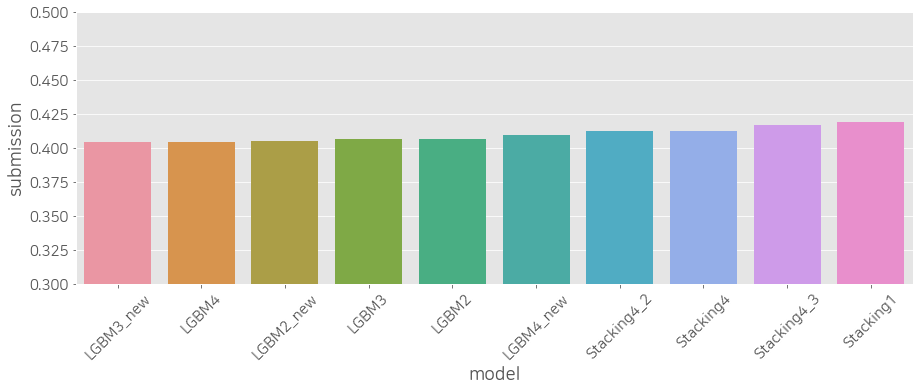

In [103]:
### submission 스코어 0.5 이하 순위 시각화 ###
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

plt.xticks(rotation=45)
plt.ylim(.3, .5)
sns.barplot(data=result[result['submission']<0.5].head(10),x='model',y='submission',ax=ax)

- *windspeed*의 보간법을 `RandomForestRegressor`에서 `LGBMRegressor`으로 변경한 데이터셋으로 동일 모델을 돌렸을 때, 성능이 더 향상되는 것을 확인할 수 있다. 보간법도 다양한 모델로 수행하여 데이터를 정확하게 정리해야함을 알 수 있다.
- stacking 모델의 경우, LGBM 보간 데이터보다 RandomForestRegressor 보간 데이터로 학습했을 때의 성능이 더 좋다.
    - 여전히 LGBM 단일 모델의 성능이 가장 좋으며 submission 스코어 0.40464로 상위 8%에 해당한다.
        > 3242팀 중 262위인데, 종료된 대회이므로 순위는 정확한 수치가 아니다

- **오늘코드**의 코드와 같은 방법으로 보간(랜덤 포레스트)하고 같은 방법으로 모델링 했음에도 불구하고 결과에 차이가 있었다. 같은 설정에도 불구하고 다른 결과를 보인 것은 <u>Computing Power</u>의 차이가 아닐까 싶다. ~~(결론은 컴퓨터를 바꾸자)~~